# The Malthus Model

Imports and set magics:

In [70]:
# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy import optimize
import sympy as sm
from scipy.optimize import minimize 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import numpy as np
from scipy.optimize import minimize

# local modules
from Model import MalthusModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model description

In this project we cosider a version of the Malthus Model.<br> Households gets utility from consumption (c) and number of surviving children (n) <br>
$u(c_t,n_t) = \ln(c_t) + \beta\ln(n_t)$ <br>
The budget constraint is: <br>
$I_t = c_t + \lambda n_t + pb_t$ <br>
, where I is income, $\lambda$ is the cost of surviving children, and p is a cost that falls on the household whether the child survives or not.<br> The variable b is the number of births. A fraction of these, $\sigma$, lead to the born children surviving until they become adults.<br>
$n_t = \sigma b_t; 0 < \sigma < 1$ <br>
Income per capita in period t is given by:<br>
$I_t=A(\frac{X}{L_t})^{1-\alpha}$<br>, where A is technology, X is land and L is population. <br>
Population in the next period is the number of surviving children, and the the part of the population that survives to the next period: <br>
$L_{t+1}=n_tL_t+(1-\mu)L_t$, where $\mu$ is adult mortality.   


# Analytical solution in Sympy

We first find the analytical solution using Sumpy. We solve the model in two steps. **In the first step** we solve the utility maximization problem, where the income is taking as given. **In the second step** we derive the transition equation for the population, where we use the optimal number of surviving children from the first step. From the transition equation we can solve for the steady state, where the population is constant. <br> To do this we first define the symbols in the model.

In [71]:
#Define the symbols
A = sm.symbols('A')
X = sm.symbols('X')
Alpha = sm.symbols('alpha')
c = sm.symbols('c')
n = sm.symbols('n_t')
I = sm.symbols('I')
Y = sm.symbols('Y')
L = sm.symbols('L_t')
L_ = sm.symbols('L_{t+1}')
beta = sm.symbols('beta')
Lambda = sm.symbols('lambda')
p = sm.symbols('p')
b = sm.symbols('b')
sigma = sm.symbols('sigma')
mu = sm.symbols('mu')

**1) Utility maximization** <br>We define the utility function and the constraints. 

In [72]:
objective = sm.ln(c)+ beta * sm.ln(n)
objective

beta*log(n_t) + log(c)

In [73]:
budget_constraint = sm.Eq(c+Lambda * n + p * b,I)
budget_constraint

Eq(b*p + c + lambda*n_t, I)

In [74]:
size = sm.Eq(sigma * b,n)
size

Eq(b*sigma, n_t)

We solve the utility maximization problem by substituting the constraints into the utility function, and differentiate w.r.t to the number of surviving children n. 

In [75]:
c_from_con = sm.solve(budget_constraint, c)
c_from_con[0]

I - b*p - lambda*n_t

In [76]:
b_size = sm.solve(size, b)
b_size[0]

n_t/sigma

In [77]:
objective_subs = objective.subs(c, c_from_con[0])
objective_subs

beta*log(n_t) + log(I - b*p - lambda*n_t)

We can now write the utility function as a funciton of only n and parameters:

In [78]:
objective_subs_1 = objective_subs.subs(b, b_size[0])
objective_subs_1

beta*log(n_t) + log(I - lambda*n_t - n_t*p/sigma)

The first order condition w.r.t n is:

In [79]:
foc = sm.diff(objective_subs_1, n)
foc

beta/n_t + (-lambda - p/sigma)/(I - lambda*n_t - n_t*p/sigma)

The optimal number of children is:

In [80]:
sol = sm.solve(sm.Eq(foc,0), n)
sol[0]

I*beta*sigma/(beta*lambda*sigma + beta*p + lambda*sigma + p)

**2) The transition equation and the steady state** <br> We first define the equations for income and population dynamics. 

In [81]:
Income = sm.Eq(A*(X/L)**(1-Alpha),I)
Income

Eq(A*(X/L_t)**(1 - alpha), I)

In [82]:
Population = sm.Eq(n*L+(1-mu)*L,L_)
Population

Eq(L_t*n_t + L_t*(1 - mu), L_{t+1})

We now insert the optimal number of surviving children from the first step 

In [83]:
Population_1 = Population.subs(n, sol[0])
Population_1

Eq(I*L_t*beta*sigma/(beta*lambda*sigma + beta*p + lambda*sigma + p) + L_t*(1 - mu), L_{t+1})

We also insert the equation for income, and derive the transition equation for population: 

In [84]:
Population_2 = Population_1.subs(I, Income.lhs)
Population_2

Eq(A*L_t*beta*sigma*(X/L_t)**(1 - alpha)/(beta*lambda*sigma + beta*p + lambda*sigma + p) + L_t*(1 - mu), L_{t+1})

We now solve for the steady state where $L_t=L_{t+1}$.

In [85]:
Population_2 = Population_2.subs(L_, L)
Population_2

Eq(A*L_t*beta*sigma*(X/L_t)**(1 - alpha)/(beta*lambda*sigma + beta*p + lambda*sigma + p) + L_t*(1 - mu), L_t)

The steady state of population is:

In [86]:
sol_1 = sm.solve(sm.Eq(Population_2.lhs,0), L)
sol_1[0]

X**(alpha/(alpha - 1))/(A*X*beta*sigma/(beta*lambda*mu*sigma - beta*lambda*sigma + beta*mu*p - beta*p + lambda*mu*sigma - lambda*sigma + mu*p - p))**(1/(alpha - 1))

The steady state of income is:

In [87]:
Income_1 = Income.subs(L, sol_1[0])
Income_1

Eq(A*(X*(A*X*beta*sigma/(beta*lambda*mu*sigma - beta*lambda*sigma + beta*mu*p - beta*p + lambda*mu*sigma - lambda*sigma + mu*p - p))**(1/(alpha - 1))/X**(alpha/(alpha - 1)))**(1 - alpha), I)

The steady state of income can be reduced to:

In [88]:
Income_ss = ((1+beta)*(Lambda+p/sigma)*mu)/beta
Income_ss

mu*(beta + 1)*(lambda + p/sigma)/beta

We convert the expression to a lambda function:

In [89]:
Income_ss_lamb = sm.lambdify((X,A,Alpha,Lambda,sigma,mu,beta,p), Income_ss)


We insert values of the parameters to get a numerical value of the steady state income per capita:

In [90]:
Income_ss_lamb(10,1,0.5,1,0.8,0.01,0.5,1)

0.0675

The steady state value of income per capita is 0.0675

# Numerical solution

We solve the model in the **MalthusModel class**. <br> <br> Below we plot the utility function for fun.

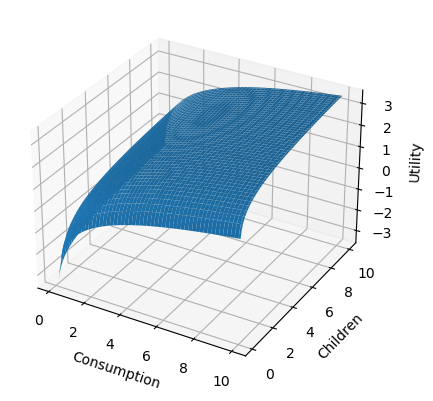

In [91]:

# Define the range of values for consumption and leisure
c_range = np.linspace(0.1, 10, 100)
n_range = np.linspace(0.1, 10, 100)

# Create a meshgrid of the range of values
c, n = np.meshgrid(c_range, n_range)

# Define the utility function
beta = 0.5
u = np.log(c) + beta * np.log(n)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(c, n, u)
ax.set_xlabel('Consumption')
ax.set_ylabel('Children')
ax.set_zlabel('Utility')
plt.show()

# Model 1

In the first model technology is constant.  

c:\Users\johan\Documents\Økonomi\8. Semester\Programming and Numerical Analysis\projects-2023-politgrammering-1\modelproject\Model.py:35: RuntimeWarning: divide by zero encountered in log
  return np.log(c) + beta*np.log(n)


Steady state population size: 2186.6610208888274
Optimal number of children: 0.01002270967739357
Steady state income: 0.06762530990136591


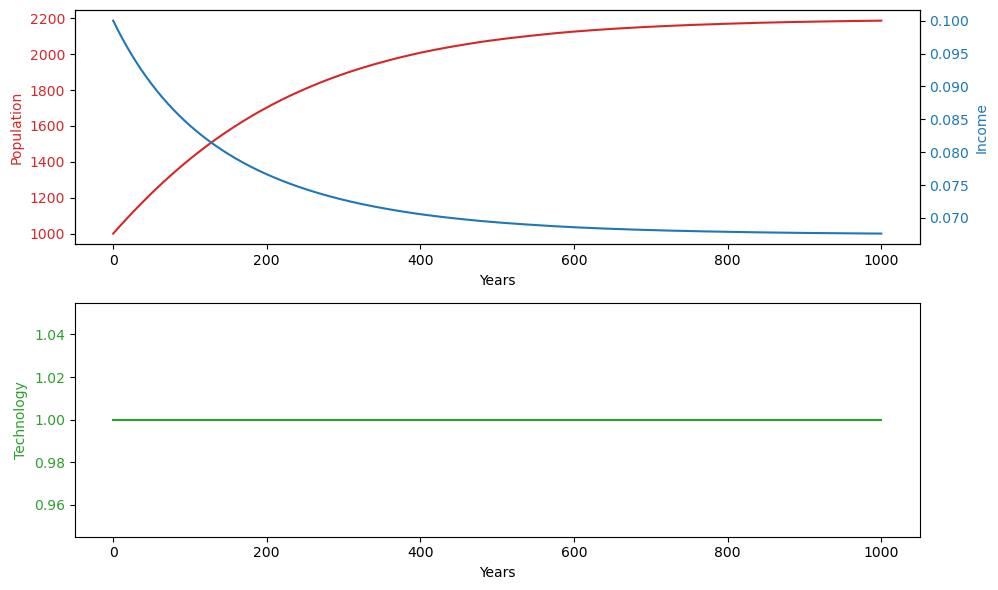

In [92]:
#Solve the model using the MalthusModel class
model = MalthusModel()
try:
    steady_state_population, optimal_num_children, steady_state_income = model.steady_state()

except:
    pass




In the plot above we have set the population (L) to 1000, as the initial value and with the given parameter values, the plot shows how population and income converges to the two steady state values. The steady state values are 2186,66 for population and 0,0676 for income given a constant level of technology.

Futhermore we see the fertility rate is 0.1, the same as the mortality rate. It is due to  the fact that in the steady state , the two values are equal and income pr. capita stagnates due to the Malthusian trap.

# Model 2

In the secound model we show a permanent shock to tecnology at t=100

Steady state population size: 8685.780776372865
Optimal number of children: 0.01006071110872335
Steady state income: 0.06786182950725307


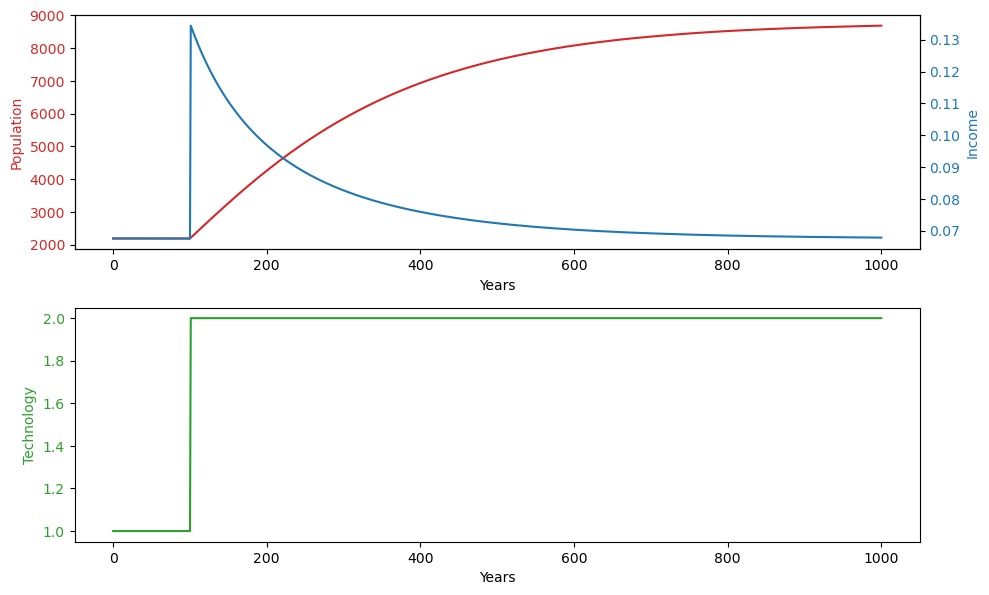

In [93]:

#Define the initial population in the steady state
model.L = 2186.661
#Use the model where a technology shock is introduced in period 100
try:
    steady_state_population, optimal_num_children, steady_state_income = model.steady_state1()

except:
    pass



From the second plot we see a permanent shock in the tecnology level where A changes from 1 to 2 at t=100 which results in an short term income increase. The population growth from  the technology shock decrease income pr. capita. Eventually income per capita converge to the same level as it was before the technology shock. The population would increase from 2186 to 8685 due to parents being able to affort more children.

# Model 3

In the thrid model we let technology grow at a constant rate

Steady state population size: 3040.747556974245
Optimal number of children: 0.010372369853871346
Steady state income: 0.0700422402787443


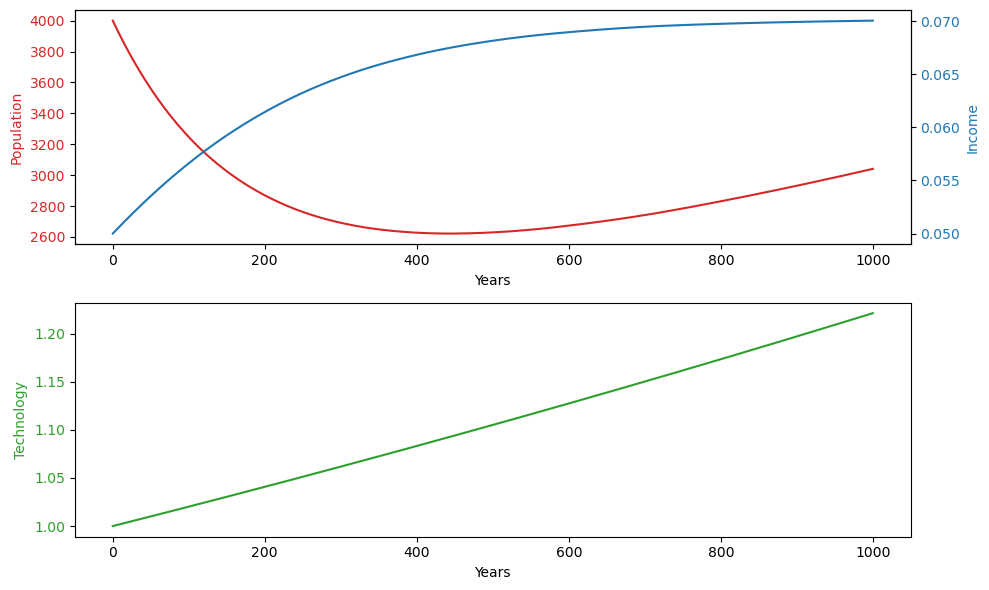

In [94]:
#Setting the initial population at 4000
#Making technology be at 1 and increase with 0.0002 each year
model.L = 4000
model.A = 1
model.g=0.0002

try:
    steady_state_population, optimal_num_children, steady_state_income = model.steady_state()

except:
    pass




For an extention of the model we have made a constant technology growth in g = 0,0002. This technological innovation cause a long term increase in population growth. After 1000 years at the maximum number of iterations it is at 3040.8. When there is a constant technology growth, there will always be a growth i population. In the long run, income will end up convergeing to the value of 0.07

# Conclusion

In this project, we have simulated the Malthus Model. In the Malthus model higher income results in having more children, because households are assumed to get utility from having children. When the population is below the steady state value, the population increases because the number of surviving children exceeds the mortality rate.
As population increases the income per capita decreases because of decreasing marginal product of labor.

Our extensions to the model are 1) to let technology jump to a permanently higher level in period t=100.
2) to let technology grow at a constant rate g.

When technology jumps to a permanently higher but constant level, income increases in the short run but converges back to the old steady state in the long run. Population converges to a new and higher steady state.

So a higher level of technology results in a higher population, but the same income per capita.

When we let technology grow at a constant rate, the population doesn't converge to a steady state but grows at a constant rate equal to g in the long run.

However, income per capita converges to a constant level because technology and population grow at the same rate.